<H1 style="text-align: center;">Hypoglycemia Detection</H1>
<H3 style="text-align: center;">EDA</H3>
###Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy

###Read Cleaned Data From File

In [10]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


###The below histogram shows how the blood glucose levels are distributed between the hypoglycemic and non hypoglycemic populations

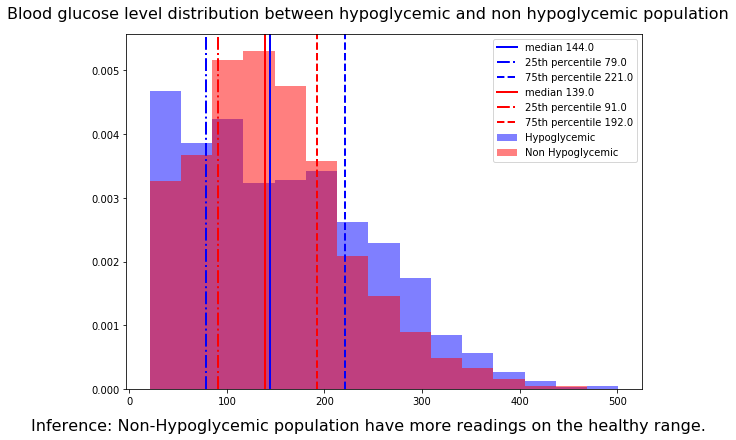

In [38]:
fig = plt.gcf()
plt.suptitle('Blood glucose level distribution between hypoglycemic and non hypoglycemic population', fontsize=16)
fig.set_size_inches(8, 6, forward=True)
df['Hypo_Flag'] = False
df.loc[df['Patient_ID'].isin(df.loc[df['Code_Description'] == 'HYPOGLYCEMIC_SYMPTOMS', 'Patient_ID'].unique()),'Hypo_Flag'] = True 

df[df['Hypo_Flag']==True].head()

plt.hist(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'], bins=15, alpha=0.5, color='b', normed=True, label='Hypoglycemic')
plt.hist(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'], bins=15, alpha=0.5, color='r',normed=True, label='Non Hypoglycemic')


plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].median(), color='b', linestyle='-', linewidth=2, 
            label='median '+str(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].median()))
plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25), color='b', linestyle='-.', linewidth=2,
           label='25th percentile '+str(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25)))
plt.axvline(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75), color='b', linestyle='--', linewidth=2,
           label='75th percentile '+str(df.loc[(df['Hypo_Flag']==True) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75)))


plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].median(), color='r', linestyle='-', linewidth=2, 
            label='median '+str(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].median()))
plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25), color='r', linestyle='-.', linewidth=2,
           label='25th percentile '+str(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.25)))
plt.axvline(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75), color='r', linestyle='--', linewidth=2,
           label='75th percentile '+str(df.loc[(df['Hypo_Flag']==False) & (df['Blood_Glucose']>20),'Blood_Glucose'].quantile(.75)))

fig.text(0.5,0, 'Inference: Non-Hypoglycemic population have more readings on the healthy range.',horizontalalignment='center',
     verticalalignment='baseline',
     size=16)

#ax.set(xlabel='Blood Glucose')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend()
#plt.xticks(range(20,int(df['Blood_Glucose'].max()),30))
plt.show()

###Aggregate Dataframe to Visualise various features

In [16]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<70]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days))
})

df_agg.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_perday,lows_perday,mean,median,nph_insulin_perday,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,4.222222,67.783333,67.783333,0.970370,6.666667,2.703704,0.000000,85.840507,0.000000
2,0.0,1.715789,0.000000,3.926316,0.000000,4.105263,100.045205,100.045205,0.021053,7.684211,3.905263,0.000000,105.922854,0.000000
3,0.0,0.657895,0.078947,3.421053,0.263158,4.394737,70.313793,70.313793,0.026316,7.631579,1.552632,0.394737,80.270788,1.842105
4,0.0,1.131579,0.026316,3.684211,0.157895,4.342105,82.479310,82.479310,1.421053,7.631579,1.789474,0.842105,96.339767,0.473684
5,0.0,1.100000,0.000000,3.600000,0.050000,4.050000,85.882759,85.882759,1.875000,7.250000,1.725000,0.900000,98.199818,0.000000


###Make The Aggregated Dataframe plotable by using pd.melt

In [17]:
df_agg_plot = df_agg.reset_index().drop('Patient_ID', axis = 1)

df_agg_plot['Hypo_Flag'] = 'Non_Hypoglycemic'

df_agg_plot.loc[df_agg_plot['hypos_perday']>0.0, 'Hypo_Flag'] = 'Hypoglycemic'

df_agg_plot['Hypo_Flag'].unique()

df_agg_plot = pd.melt(df_agg_plot, id_vars=['Hypo_Flag'], var_name='params')

df_agg_plot.head()

,Hypo_Flag,params,value
0,Hypoglycemic,exercise_perday,0.0
1,Non_Hypoglycemic,exercise_perday,0.0
2,Hypoglycemic,exercise_perday,0.0
3,Hypoglycemic,exercise_perday,0.0
4,Non_Hypoglycemic,exercise_perday,0.0


<H3 style="text-align: center;">Plotting</H3>
###The below plot compares the median and STD of the hypoglycemic and non hypoglycemic people in the dataset.
Note : A patient is considered hypoglycemic if the patient has had atleast one hypoglycemic symptom.
    A patient is considered non hypoglycemic if the patient has had ZERO hypoglycemic symptoms

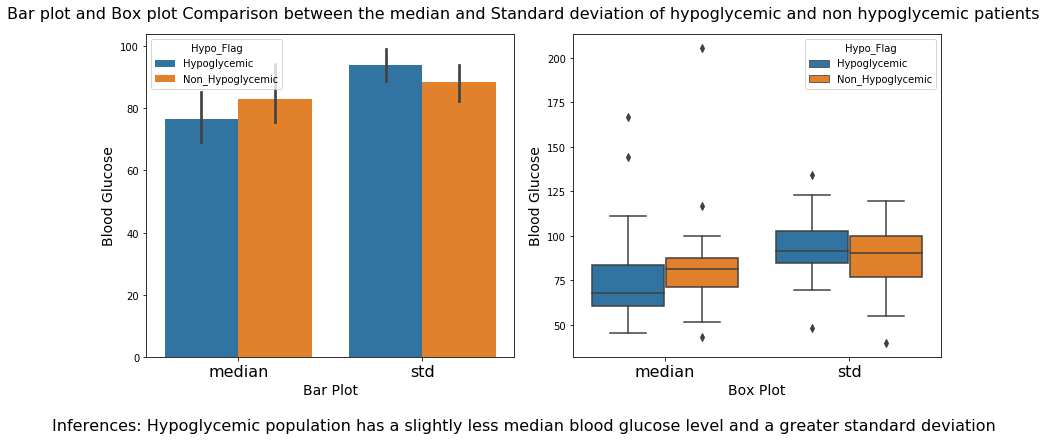

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plt.suptitle('Bar plot and Box plot Comparison between the median and Standard deviation of hypoglycemic and non hypoglycemic patients', fontsize=16)
#plt.subplots_adjust(top=2)
sns.barplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'median') | (df_agg_plot['params']  == 'std')], ax=ax1)
ax1.set_xlabel('Bar Plot', fontsize=14)
ax1.set_ylabel('Blood Glucose', fontsize=14)
ax1.tick_params(axis='x', which='major', labelsize=16)

sns.boxplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'median') | (df_agg_plot['params']  == 'std')], ax=ax2)    
ax2.set_xlabel('Box Plot', fontsize=14)
ax2.set_ylabel('Blood Glucose', fontsize=14)

fig.set_size_inches(12, 6)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
ax2.tick_params(axis='x', which='major', labelsize=16)
fig.text(0.5, 0,'Inferences: Hypoglycemic population has a slightly less median '+
         'blood glucose level and a greater standard deviation',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=16)
plt.show()

In [19]:
print('Median Quantiles for hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']>0.0, 'median'].quantile([.25,.5,.75]),
      '\nMedian Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'median'].quantile([.25,.5,.75]),
      '\nSTD Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'std'].quantile([.25,.5,.75]),
      '\nSTD Quantiles for non hypoglycemic patients\n',
      df_agg.loc[df_agg.loc[:,'hypos_perday']==0.0, 'std'].quantile([.25,.5,.75]))

Median Quantiles for hypoglycemic patients
 0.25    60.710345
0.50    67.736494
0.75    83.864003
Name: median, dtype: float64 
Median Quantiles for non hypoglycemic patients
 0.25    71.086207
0.50    81.196766
0.75    87.540289
Name: median, dtype: float64 
STD Quantiles for non hypoglycemic patients
 0.25     76.963331
0.50     90.613977
0.75    100.066212
Name: std, dtype: float64 
STD Quantiles for non hypoglycemic patients
 0.25     76.963331
0.50     90.613977
0.75    100.066212
Name: std, dtype: float64


In [ ]:
###Below Plot Compares the different habits of hypoglycemic and non hypoglycemic populations.
Note : The 

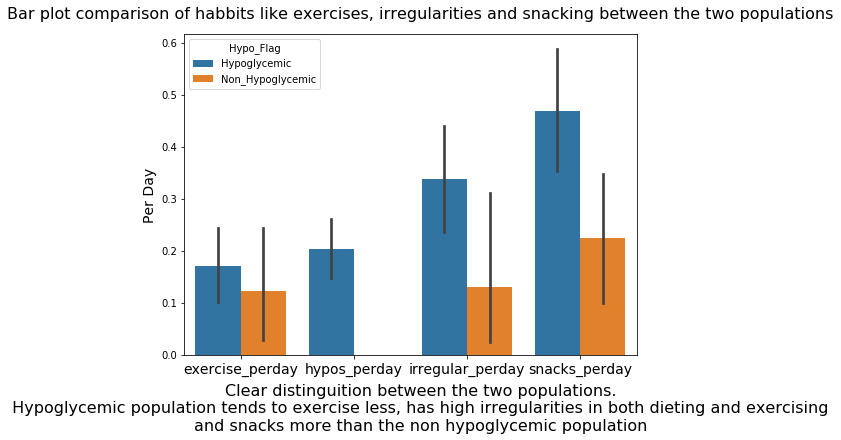

In [20]:
fig = plt.gcf()
plt.suptitle('Bar plot comparison of habbits like exercises, irregularities and snacking between the two populations', fontsize=16)
fig.set_size_inches(8, 6, forward=True)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", 
            data=df_agg_plot.loc[(df_agg_plot['params']  == 'exercise_perday') | 
                                 (df_agg_plot['params']  == 'hypos_perday') | 
                                 (df_agg_plot['params']  == 'irregular_perday') | 
                                 (df_agg_plot['params']  == 'snacks_perday')])    

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Per Day', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
fig.text(0.5, 0,'Clear distinguition between the two populations.\n '+
         'Hypoglycemic population tends to exercise less, has high irregularities in both dieting and exercising '+
         '\nand snacks more than the non hypoglycemic population',
     horizontalalignment='center',
     verticalalignment='baseline',
     size=16)
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])

plt.show()



###The below plot compares the number of high and low blood glucose levels and number of readings per day between the hypoglycemic and non hypoglycemic population

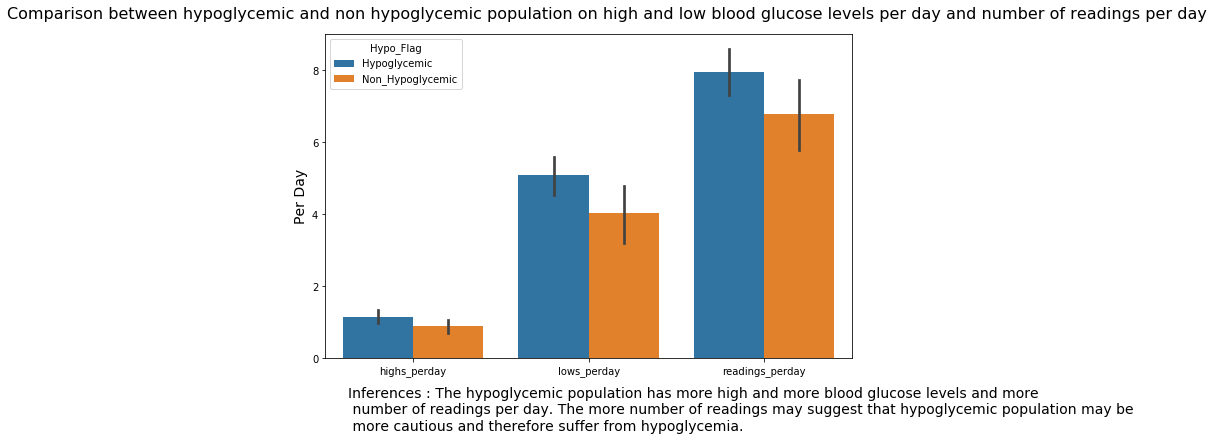

In [21]:
fig = plt.gcf()
fig.suptitle('Comparison between hypoglycemic and non hypoglycemic population on high and low blood glucose levels per day and number of readings per day', fontsize=16)
fig.set_size_inches(9, 6, forward=True)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'highs_perday') | (df_agg_plot['params']  == 'lows_perday') |(df_agg_plot['params']  == 'readings_perday')])    
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Per Day', fontsize=14)

fig.text(0.1, 0, 'Inferences : The hypoglycemic population has more high and more blood glucose levels and more\n'+
        ' number of readings per day. The more number of readings may suggest that hypoglycemic population may be\n'+
         ' more cautious and therefore suffer from hypoglycemia.', size=14);
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
plt.show()

###The below plot compares the insulin usage of hypoglycemic and non hypoglycemic population

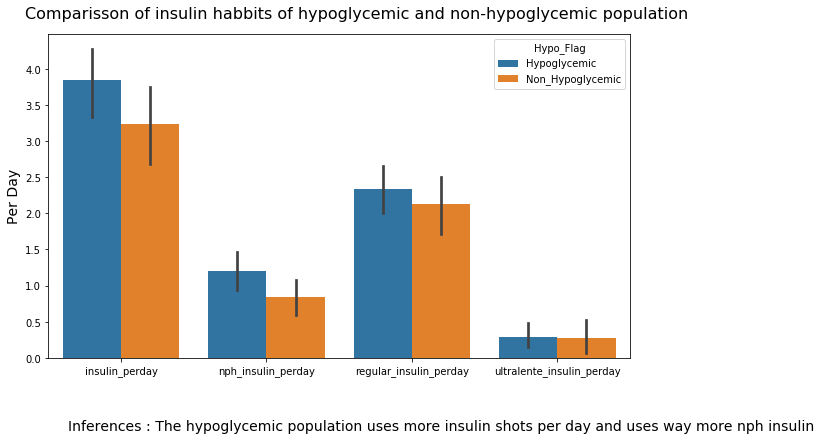

In [22]:
fig = plt.gcf()
fig.set_size_inches(10, 6, forward=True)
fig.suptitle('Comparisson of insulin habbits of hypoglycemic and non-hypoglycemic population', fontsize=16)
ax = sns.barplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'regular_insulin_perday') | (df_agg_plot['params']  == 'nph_insulin_perday') | (df_agg_plot['params']  == 'ultralente_insulin_perday') | (df_agg_plot['params']  == 'insulin_perday')])    
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Per Day', fontsize=14)

fig.text(0.1, 0, 'Inferences : The hypoglycemic population uses more insulin shots per day and uses way more nph insulin', size=14);
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])

plt.show()

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 6, forward=True)
fig.suptitle('Distribution Of Hypoglycemic symptoms based on hour of the day.', fontsize=16)

ax = sns.distplot(df.loc[df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS', 'Date_Time'].dt.hour, kde=True,bins=12, 
             label='Hypoglycemic', hist_kws={"color": "b", "alpha":0.5}, axlabel='Hour Of The Day')
ax.set_ylabel('Hypoglycemic events', fontsize=14)

fig.text(0.1, 0, 'Inferences : Most hypoglycemic symptoms are during the day and it peaks in the afternoon.', size=14);
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])

plt.show()

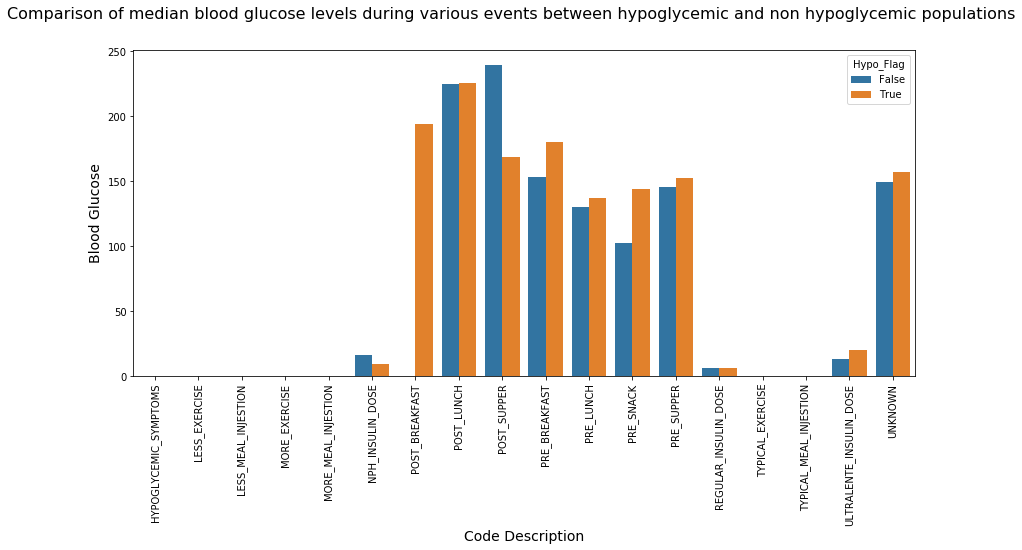

In [23]:
fig = plt.gcf()
fig.set_size_inches(14, 6, forward=True)
fig.suptitle('Comparison of median blood glucose levels during various events between hypoglycemic and non hypoglycemic populations', fontsize=16)
ax = sns.barplot(x="Code_Description", y="Blood_Glucose", hue="Hypo_Flag", data=df.groupby(['Code_Description', 'Hypo_Flag']).agg(np.median).reset_index())  
ax.set_xlabel('Code Description', fontsize=14)
ax.set_ylabel('Blood Glucose', fontsize=14)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

###Add Hypo_Day flag based on whether the the patient had experienced hypoglycemia on that particular day.

In [24]:
df['Date'] = df['Date_Time'].dt.date
df['Hypo_Day_Flag'] = 'No_Hypo_Day'

group_df = df.groupby(['Date', 'Code_Description', 'Patient_ID']).size().reset_index()

group_df = group_df[group_df[['Date', 'Code_Description', 'Patient_ID']].Code_Description == 'HYPOGLYCEMIC_SYMPTOMS']

df.loc[(df['Patient_ID'].isin(group_df['Patient_ID'])) & (df['Date'].isin(group_df['Date'])), 'Hypo_Day_Flag'] = 'Hypo_Day'


df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time,Hypo_Flag,Date,Hypo_Day_Flag
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00,False,1991-05-20,No_Hypo_Day
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,False,1991-05-20,No_Hypo_Day
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00,False,1991-05-20,No_Hypo_Day
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00,False,1991-05-20,No_Hypo_Day
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,False,1991-05-20,No_Hypo_Day


In [28]:
df_hypo_patients = df[df['Hypo_Flag']].groupby(['Hypo_Day_Flag','Code_Description'])['Blood_Glucose'].agg(np.median).reset_index()
df_hypo_patients.head()

,Hypo_Day_Flag,Code_Description,Blood_Glucose
0,Hypo_Day,HYPOGLYCEMIC_SYMPTOMS,0.0
1,Hypo_Day,LESS_EXERCISE,0.0
2,Hypo_Day,LESS_MEAL_INJESTION,0.0
3,Hypo_Day,MORE_EXERCISE,0.0
4,Hypo_Day,MORE_MEAL_INJESTION,0.0


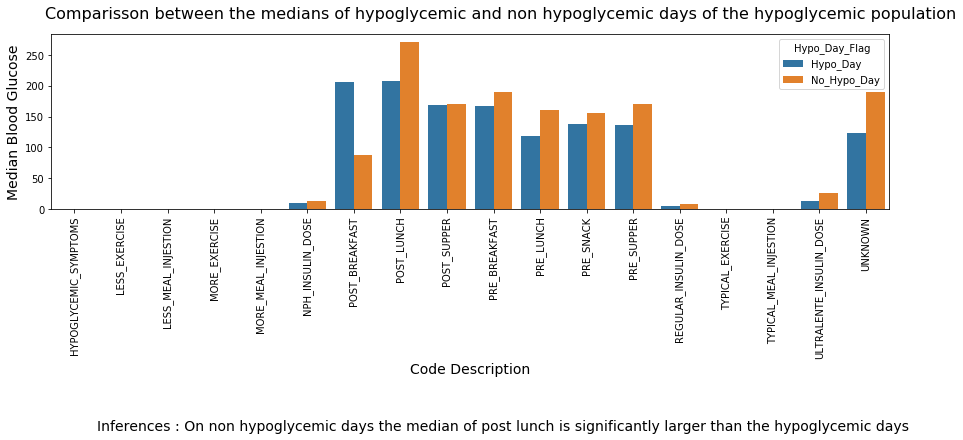

In [29]:
fig = plt.gcf()
fig.set_size_inches(14, 6, forward=True)
fig.suptitle('Comparisson between the medians of hypoglycemic and non hypoglycemic days of the hypoglycemic population', fontsize=16)
ax = sns.barplot(x="Code_Description", y="Blood_Glucose", hue="Hypo_Day_Flag", data=df_hypo_patients) 
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
fig.text(0.1, 0, 'Inferences : On non hypoglycemic days the median of post lunch is significantly larger than the hypoglycemic days', size=14);
ax.set_xlabel('Code Description', fontsize=14)
ax.set_ylabel('Median Blood Glucose', fontsize=14)
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
plt.show()

<H3 style="text-align: center;">Conclusion</H3>
<BR>
<P>The dataset was analysed by comparing the blood glucose levels of patients who experienced hypoglycemic symptoms and people who did not experience the same. Analysis was also performed to see trends on patients with hypoglycemia by comparing their blood glucose levels on the days the hypoglycemic event was experienced and not experienced.<BR> The findings are as below. </p>

<ul>
<li>The non hypoglycemic population had dangerously low blood glucose levels too but they have not experienced any hypoglycemic symptoms. This may be because of a condition called hypoglycemic unawareness. The study of this condition is beyound the scope of this project and will be ignored</li>
<li>The median blood glucose level for hypoglycemic population is slightly higher for non hypoglycemic population</li>
<li>The standard deviation of blood glucose level is slightly higher for the hypoglycemic population</li>
<li>The hypoglycemic population exercises more than the non-hypoglycemic population. This may imply that tight control may be one of the reasons for hypoglycemia.</li>
<li>The hypoglycemic population was significantly irregular in their day to day activities than their counterparts.</li>
<li>The hypoglycemic population snacked more than their counterparts.</li>
<li>The hypoglycemic population had significantly more blood glucose readings than their counterparts. This may suggest that strict control may be causing hypoglycemia in these patients.</li>
<li>The hypoglycemic population takes more insulin shots per day. This may suggest irregularities. </li>
<li>NPH insulin users have slightly higher chances of experiencing hypoglycemia than non users.</li>
<li>Most hypoglycemic events happen during the afternoon 12 noon and 6pm</li>
<li>The hypoglycemic population had significantly higher blood glucose levels post lunch on non hypoglycemic days than on hypoglycemic days</li>
</ul>